# MT tip simulation 
Model tip fluctuations and their contributions in a 1D fashion

Including 'B-C model' suggesting 2 different states at tip (B, C), 
Ignoring the extra state "A" (as introduced in Maurer et al. 2014)

In [1]:
# Import packages
import numpy as np
from time import clock, strftime
from datetime import date
import os, shutil #modules for file handling
from matplotlib import pyplot as plt
from scipy import stats
import pickle

In [2]:
# Default folder
ROOT  = os.getcwd()
ROOT = ROOT.replace('notebooks','')

# User defined folder
# ROOT = 'C:\\'

import sys
sys.path.insert(0, ROOT)

In [3]:
# Initialize random number generator:
np.random.seed(42) #int(100*clock()))

# Import functions
import simulation_functions as sFUNC #import simulation functions
import simulation_parameters as simParameters #import simulation parameters
import simulation_main as sMAIN #import main simulation function
import plotting_functions as plotf #import plotting functions
from parameters import ParameterSet

growth speed set to:  1.8


### Load parameters from simulation_parameters.py

In [4]:
simPa = ParameterSet(simParameters.simParameters)

### Create folder based on date

In [5]:
# Read actual time + date
DATE = str(date.today())
TIME = str(strftime('%X'))
TIME = TIME.replace(':','-')

# Create main folder to save data
PATH_RESULTS = ROOT + 'SIM_RUNS\\' + DATE + '___' + TIME +'\\'

if simPa.record_data == True:
    os.makedirs(PATH_RESULTS) # create (sub)folder    

### Inspect simulation parameters:

In [6]:
simPa

{'record_data': True,
 'record_data_full': False,
 'plot_figures': True,
 'compare_results': False,
 'end_hydrolysis': True,
 'frame_rate_aim': 0.25,
 'record_cap': False,
 'record_length': False,
 'steady_state_analysis': False,
 'EB': 0,
 'growth_speed': 1.8,
 'dL_dimer': 0.0006153846153846154,
 'growth_rate_one': 48.75,
 'kBC': 0.1,
 'D_tip': 2000,
 'unstable_cap_criteria': 15,
 'seed_resolution': 0.005,
 'unstable_cap_time': False,
 'unstable_cap_start': 30,
 'unstable_cap_end': 15,
 'unstable_cap_rate': 0.007,
 'D_tip_time': False,
 'D_tip_start': 666.6666666666666,
 'D_tip_end': 2500.0,
 'D_tip_rate_T': 0.02,
 'D_tip_length': False,
 'D_tip_rate_L': 0.2,
 'kBC_time': False,
 'kBC_start': 0.05,
 'kBC_end': 0.1,
 'kBC_rate': 0.005,
 'barrier': False,
 'DXbarrier': 0.005,
 'CAP_threshold': 0.0,
 'no_cat': 500,
 'max_MT_growth_time': 2000,
 'too_stable_check': 5,
 'total_max_time': 250000,
 'P_max': 0.05,
 'tip_window': 1.0,
 'nucleation_threshold': 400,
 'show_fraction': 40,
 'min_l

### Change parameters where necessary:

In [7]:
simPa.no_cat = 500
simPa.kBC = 0.25
simPa.D_tip = 3500

# Start actual simulation run

In [8]:
dt, MT_length_sum, MT_length_full, CATASTROPHE_TIMES, CATASTROPHE_LENGTH, barrier_contact_times, \
EB_comet_sum, cap_end, Cap_threshold, frame_rate_actual, EB_profiles, washout_times, \
catastrophe_washout, cap_end_sum  = sMAIN.MT_RUN(simPa)

EB:  0    kBC:  0.25    D_tip:  3500
--- time step dt = 0.185 s
--- MTs growth  9  dimers per step (D_tip =  3500  -> noise STD=  58.41660722773962  )
 catastrophes:  1000  of  1000tastrophes:  48  of  1000catastrophes:  63  of  10001000catastrophes:  123  of  1000 204  of  1000 10001000 of  1000catastrophes:  383  of  10001000  of  1000  of  1000 1000catastrophes:  977  of  1000 1000

### Store parameters and executed code

In [9]:
# Update parameters based on simulation run:
simPa.dt = dt
simPa.frame_rate_actual = frame_rate_actual

# Store code and parameters
if simPa.record_data == True: 
    # Save running code in folder for later documentation/re-runs
    # running_filename = ROOT + 'simulation_run.py'
    running_filename = ROOT + '\\notebooks\\' + 'MT_simulation_single_run.ipynb'
    
    #running_filename = (sys.path[1] + '\\simulation_run.py')
    shutil.copy(running_filename,(PATH_RESULTS + 'executed_code.py'))
    shutil.copy(ROOT + 'simulation_parameters.py',(PATH_RESULTS + 'parameters_used.txt'))
    shutil.copy(ROOT + 'simulation_functions.py',(PATH_RESULTS + 'functions_used.txt'))
    shutil.copy(ROOT + 'simulation_main.py',(PATH_RESULTS + 'main_function_used.txt'))

    sFUNC.dict_to_json(simParameters.simParameters, PATH_RESULTS + 'simulation_parameters.json')

### Correct nucleation delay
Find the timepoint that each MT reaches a length of 250 nm and subtract this from the catastrophe time

In [10]:
if simPa.nucleation_threshold > 0:
    nucleation_times = np.zeros(len(MT_length_full))
    for i in range(len(MT_length_full)):
        temp = np.array(MT_length_full[i])
        nucl = np.argmax(temp > (temp[0] + simPa.nucleation_threshold))
        nucleation_times[i] = dt*nucl
        CATASTROPHE_TIMES[i] = CATASTROPHE_TIMES[i] - nucleation_times[i]  
        
        # Remove elements prior to nucleation threshold
        del EB_comet_sum[i][len(EB_comet_sum[i])-nucl:]
        del MT_length_full[i][:nucl]
        del cap_end[i][:nucl]
        del EB_profiles[i][:nucl]

    # Remove all values smaller than 0
    CATASTROPHE_TIMES = [x for x in CATASTROPHE_TIMES if x > 0]

### Store simulation results (as pickle)

In [11]:
if simPa.record_data_full or simPa.record_data: 
    SIM_results = [dt, MT_length_sum, MT_length_full, CATASTROPHE_TIMES, CATASTROPHE_LENGTH, 
                   barrier_contact_times, EB_comet_sum, cap_end, Cap_threshold,
                   frame_rate_actual, EB_profiles]    
    
    filename = PATH_RESULTS + 'SIM_RUN.data'     
    
    with open(filename, 'wb') as filehandle:  
        # Store the data as binary data stream
        pickle.dump(SIM_results, filehandle)
        
# Collect microtubule cap position and EB comet size in single list for export or later processing
if simPa.record_data_full:        
    MT_Data = []       
    for i in range(len(SIM_results[2])):
        temp = np.zeros((4,len(SIM_results[2][i])))
        temp[0] =[k*dt for k in range(len(SIM_results[2][i]))]
        temp[1] = SIM_results[2][i]
        temp[2] = SIM_results[7][i]
        temp[3] = list(reversed(SIM_results[6][i]))
        MT_Data.append(np.transpose(temp))        
        
    os.mkdir(PATH_RESULTS + 'MTs\\')    
    for k in range(len(MT_Data)):
        if k < 10:
            num = '000' + str(k)
        elif k < 100:
            num = '00' + str(k)
        elif k < 1000:
            num = '0' + str(k)
        else:
            num = str(k)
            
        filename = PATH_RESULTS + 'MTs\\' + 'MT_' + num + '.csv'
        np.savetxt(filename, MT_Data[k], delimiter=",")

# Analysis + Plotting of Simulation results

In [12]:
# Prepare data
if simPa.barrier:
    if len(CATASTROPHE_TIMES) > 1:
        catastrophe_times = np.array(CATASTROPHE_TIMES) 
    else:
        catastrophe_times = np.zeros(0)
    Cum_dist = barrier_contact_times
    Cum_dist = np.sort(Cum_dist)
else:
    if len(CATASTROPHE_TIMES) > 1:
        catastrophe_times = np.array(CATASTROPHE_TIMES) 
    else:
        catastrophe_times = np.zeros(0)
    Cum_dist = catastrophe_times
    Cum_dist = np.sort(Cum_dist)

Cum_dist_exp = []
file_figure = PATH_RESULTS + DATE  

# Plot figures

1
(0.95, 0.1, 0.1)


C:\Users\Maurits\Documents\Python Scripts\mt-dynamics\plotting_functions.py:577: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.ax = fig.add_subplot(111)


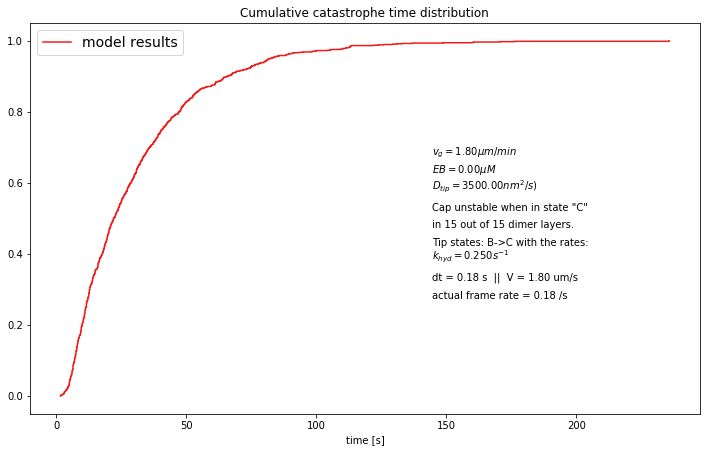

C:\Users\Maurits\Documents\Python Scripts\mt-dynamics\plotting_functions.py:1217: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.ax = fig.add_subplot(111)
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


[1.49181599 0.05117941]
[[6.89148051e-05 2.89406061e-06]
 [2.89406061e-06 1.29543073e-07]]


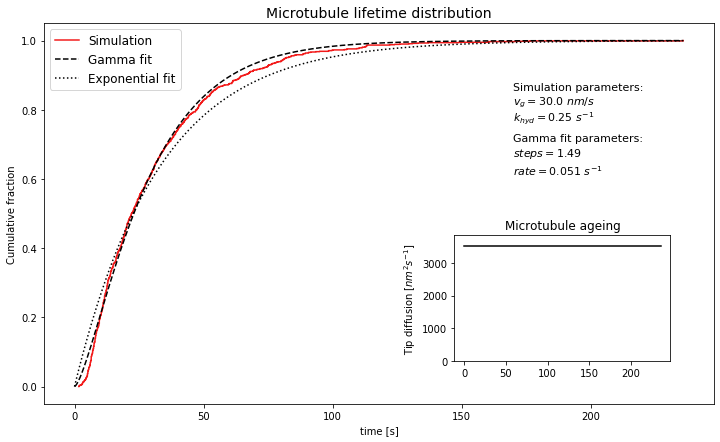

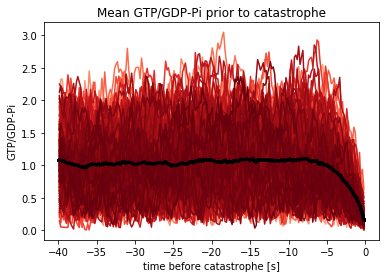

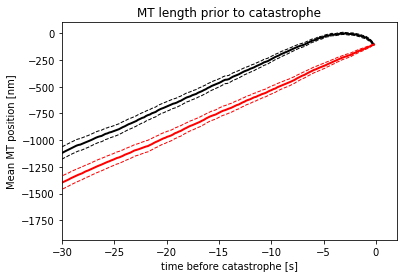

Mean shrinkage before catastrophe = 104.98 nm
Mean pause duration before catastrophe = 4.25 s


C:\Users\Maurits\Documents\Python Scripts\mt-dynamics\plotting_functions.py:1072: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.ax = fig.add_subplot(111)


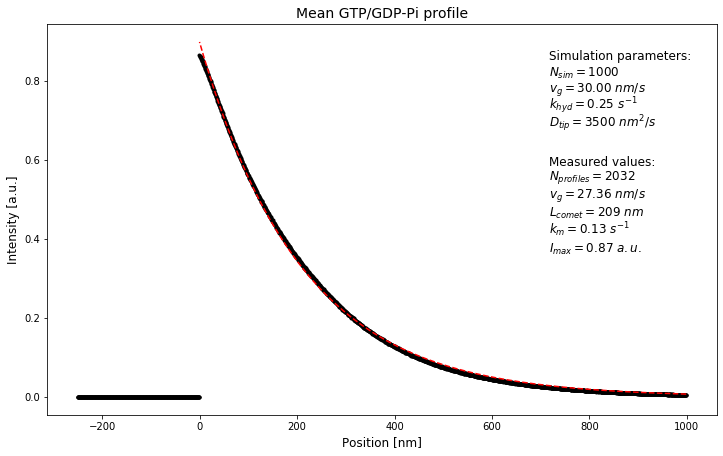

In [13]:
if simPa.plot_figures:        

    #FIG 1,... ----- catastrophe time distribution -----------------------------   
#    if len(Cum_dist_exp) > 0:
#        plotf.fig_cat_dist(simPa, file_figure, 1, catastrophe_times, Cum_dist_exp)
            
    # FIG 2,... ----- Plot cumulative catastrophe distribution ------------------
    if len(Cum_dist_exp) > 0:
        plotf.fig_cat_cumulative(simPa, file_figure, 2, Cum_dist, Cum_dist_compare = Cum_dist_exp)
    else:
        plotf.fig_cat_cumulative(simPa, file_figure, 2, Cum_dist)
    
    # FIG 2,... ----- Plot cumulative catastrophe distribution with fits------------------
    if not simPa.washout and not simPa.barrier:
        plotf.fig_dist_fit(simPa, file_figure, 2, Cum_dist, dt)
    
    
    # FIG 3 ----------- EB signal at barrier ------------------------------------ 
    if simPa.barrier: #if barrier present
        plotf.fig_EB_at_barrier(simPa, file_figure, 3, EB_comet_sum, barrier_contact_times)
        
     
    # FIG 4 ----------- EB signal before catastrophe ----------------------------
    if simPa.barrier: #if barrier present
        plotf.fig_EB_before_cat(simPa, file_figure, 4, EB_comet_sum, barrier_contact_times)
    else: 
        EB_bef_cat = plotf.fig_EB_before_cat(simPa, file_figure, 4, EB_comet_sum)
       
    # FIG 5 ----------- MT length before catastrophe ----------------------------
    MT_bef_cat, C_bef_cat = plotf.fig_MT_before_cat(simPa, file_figure, 5, MT_length_sum, cap_end_sum)
            
    # FIG 6 ----------- EB at catastrophe histograms ----------------------------
    if simPa.barrier:
        plotf.fig_EB_cat_hist(simPa, file_figure, 6, EB_comet_sum, 
                              barrier_contact_times, EB_average_frames = 2)   
    
    # FIG 7 ---------- EB profile during steady-state growth --------------------
    plotf.fig_EB_profile(simPa, file_figure, 7, EB_profiles, MT_length_full, w_size = 55)
  
    
    # FIG 8 ---------- Size of the cap before catastrophe -------------------- 
#    if not simPa.washout and not simPa.barrier:
#        plotf.fig_cap_size_before_cat(simPa,file_figure, 7, MT_length_full, cap_end)
    
    
    # FIG 9 ---------------- Microtubule ageing --------------------------------
#    if not simPa.washout and not simPa.barrier:
#       C_freq = plotf.fig_MT_ageing(simPa, file_figure, 9, catastrophe_times)
   
    
    # FIG 10 ---------------- Tubulin washout --------------------------------
    if simPa.washout:
        plotf.fig_washout(simPa,file_figure, 10, washout_times, catastrophe_washout, MT_length_sum) 
    
    # FIG 11 --------------- Examples of catastrophes--------------------------
#    plotf.fig_display_examples(simPa, file_figure, 11, MT_length_sum, catastrophe_times, EB_comet_sum, barrier_contact_times)  
    
    # FIG 12 ---------- Verification of simulated microtubule growth -------------
#    plotf.fig_sim_verification(simPa, file_figure, 12, MT_length_full, cap_end, 1)